<style>
@font-face {
  font-family: CharisSILW;
  src: url(files/CharisSIL-R.woff);
}
@font-face {
  font-family: CharisSILW;
  font-style: italic;
  src: url(files/CharisSIL-I.woff);
}
@font-face {
	font-family: CharisSILW;
	font-weight: bold;
	src: url(files/CharisSIL-B.woff);
}
@font-face {
	font-family: CharisSILW;
	font-weight: bold;
	font-style: italic;
	src: url(files/CharisSIL-BI.woff);
}

div.cell, div.text_cell_render{
    max-width:1000px;
}

h1 {
    text-align:center;
    font-family: Charis SIL, CharisSILW, serif;
}

.rendered_html {
    font-size: 130%;
    line-height: 1.3;
}

.rendered_html li {
    line-height: 2;
}

.rendered_html h1{
    line-height: 1.3;
}

.rendered_html h2{
    line-height: 1.2;
}

.rendered_html h3{
    line-height: 1.0;
}

.text_cell_render {
    font-family: Charis SIL, CharisSILW, serif;
    line-height: 145%;
}

li li {
    font-size: 85%;
}
</style>

Lab
==========================================
Gradient Boosted Regression Trees
------------------------------------------
Alessandro D. Gagliardi  
*(adapted from Peter Prettenhofer's tutorial)*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import plt

from sklearn.cross_validation import train_test_split

%matplotlib inline

Scikit-learn provides two estimators for gradient boosting: ``GradientBoostingClassifier`` and ``GradientBoostingRegressor``, both are located in the ``sklearn.ensemble`` package:

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

Estimators support arguments to control the fitting behaviour -- these arguments are often called _hyperparameters_. Among the most important ones for GBRT are:

  * number of regression trees (``n_estimators``)
  * depth of each individual tree (``max_depth``)
  * loss function (``loss``)

For example if you want to fit a regression model with 100 trees of depth 3 using least-squares:

In [3]:
est = GradientBoostingRegressor(n_estimators=100, max_depth=3, loss='ls')

Here is an self-contained example that shows how to fit a ``GradientBoostingClassifier`` to a synthetic dataset:

In [6]:
from sklearn.datasets import make_hastie_10_2
from sklearn.cross_validation import train_test_split

# generate synthetic data from ESLII - Example 10.2
X, y = make_hastie_10_2(n_samples=5000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# fit estimator
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(X_train, y_train)

# predict class labels
pred = est.predict(X_test)

# score on test data (accuracy)
acc = est.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est.predict_proba(X_test)[0]

ACC: 0.9136


array([ 0.81791667,  0.18208333])

The state of the estimator is stored in instance attributes that have a trailing underscore ('\_'). For example, the sequence of regression trees (``DecisionTreeRegressor`` objects) is stored in ``est.estimators_``:

In [7]:
est.estimators_[0, 0]

DecisionTreeRegressor(compute_importances=None,
           criterion=<sklearn.tree._tree.FriedmanMSE object at 0x1097d4b28>,
           max_depth=3, max_features=None, max_leaf_nodes=None,
           min_density=None, min_samples_leaf=1, min_samples_split=2,
           random_state=<mtrand.RandomState object at 0x104cc3290>,
           splitter=<sklearn.tree._tree.PresortBestSplitter object at 0x109884158>)

## Gradient Boosted Regression Trees in Practise

### Function approximation

  * Sinoide function + random gaussian noise 
  * 80 training (blue), 20 test (red) points

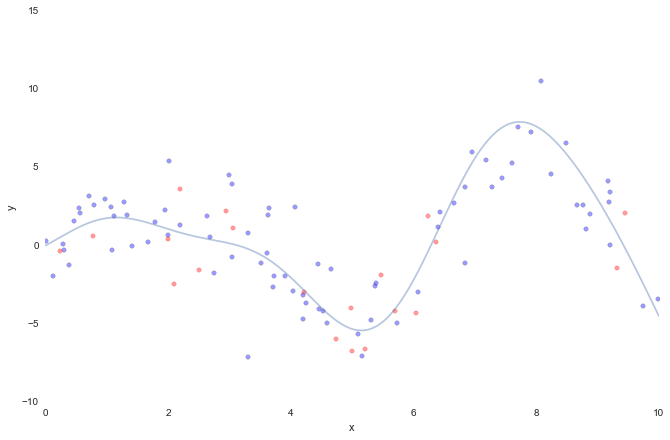

In [8]:
FIGSIZE = (11, 7)

def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    np.random.seed(15)
    X = np.random.uniform(0, 10, size=n_samples)[:, np.newaxis]
    y = ground_truth(X.ravel()) + np.random.normal(scale=2, size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_data(100)

# plot ground truth
x_plot = np.linspace(0, 10, 500)

def plot_data(alpha=0.4, s=20):
    fig = plt.figure(figsize=FIGSIZE)
    gt = plt.plot(x_plot, ground_truth(x_plot), alpha=alpha, label='ground truth')

    # plot training and testing data
    plt.scatter(X_train, y_train, s=s, alpha=alpha)
    plt.scatter(X_test, y_test, s=s, alpha=alpha, color='red')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('x')
    
annotation_kw = {'xycoords': 'data', 'textcoords': 'data',
                 'arrowprops': {'arrowstyle': '->', 'connectionstyle': 'arc'}}
    
plot_data()

### Regression Trees

  * ``max_depth`` argument controlls the depth of the tree
  * The deeper the tree the more variance can be explained

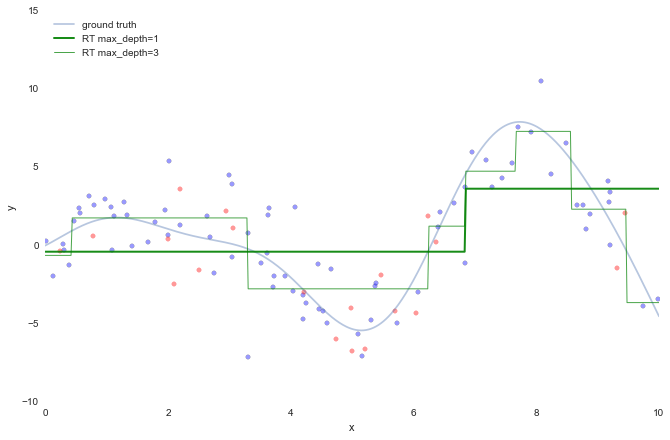

In [9]:
from sklearn.tree import DecisionTreeRegressor
plot_data()
est = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=1', color='g', alpha=0.9, linewidth=2)

est = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=3', color='g', alpha=0.7, linewidth=1)

plt.legend(loc='upper left')

### Function approximation with Gradient Boosting

  * ``n_estimators`` argument controls the number of trees
  * ``staged_predict`` method allows us to step through predictions as we add more trees

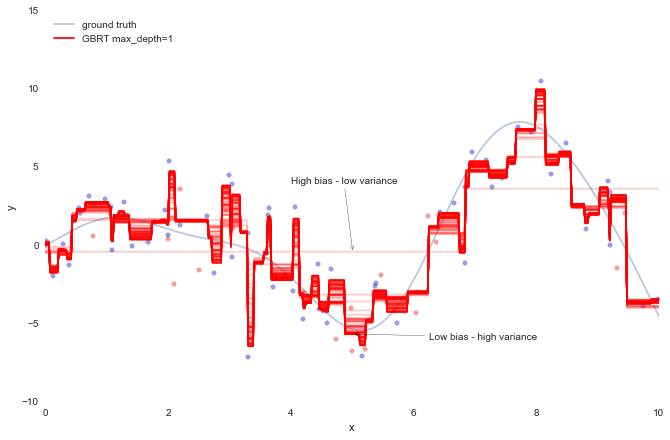

In [10]:
from itertools import islice

plot_data()
est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

ax = plt.gca()
first = True

# step through prediction as we add 10 more trees.
for pred in islice(est.staged_predict(x_plot[:, np.newaxis]), 0, est.n_estimators, 10):
    plt.plot(x_plot, pred, color='r', alpha=0.2)
    if first:
        ax.annotate('High bias - low variance', xy=(x_plot[x_plot.shape[0] // 2],
                                                    pred[x_plot.shape[0] // 2]),
                                                    xytext=(4, 4), **annotation_kw)
        first = False

pred = est.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color='r', label='GBRT max_depth=1')
ax.annotate('Low bias - high variance', xy=(x_plot[x_plot.shape[0] // 2],
                                            pred[x_plot.shape[0] // 2]),
                                            xytext=(6.25, -6), **annotation_kw)
plt.legend(loc='upper left')

### Model complexity

  * The number of trees and the depth of the individual trees control model complexity
  * Model complexity comes at a price: **overfitting**
  
  
### Deviance plot

  * Diagnostic to determine if model is overfitting
  * Plots the training/testing error (deviance) as a function of the number of trees (=model complexity)
  * Training error (deviance) is stored in ``est.train_score_``
  * Test error is computed using ``est.staged_predict``

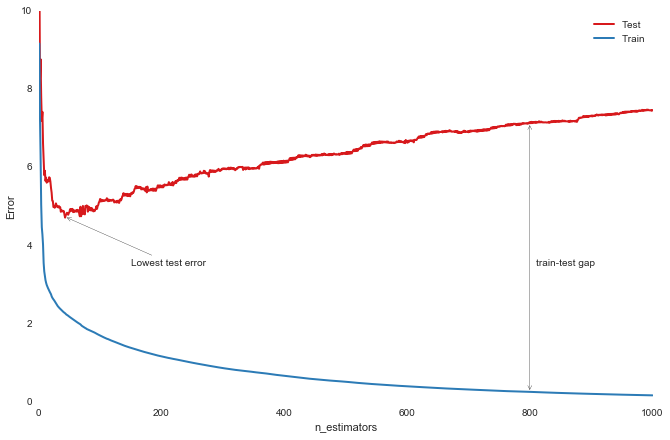

In [11]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=FIGSIZE)
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc='upper right')

# add some annotations
ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02),
            xytext=(150, 3.5), **annotation_kw)

ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
                  xytext=(800, est.train_score_[799]), textcoords='data',
                  arrowprops={'arrowstyle': '<->'})
ax.text(810, 3.5, 'train-test gap')

### Overfitting

  * Model has too much capacity and starts fitting the idiosyncracies of the training data
  * Indicated by a large gap between train and test error
  * GBRT provides a number of knobs to control overfitting

## Regularization

  * Tree structure
  * Shrinkage
  * Stochastic Gradient Boosting

## Tree Structure

  * The ``max_depth`` of the trees controls the degree of features interactions (variance++)
  * Use ``min_samples_leaf`` to have a sufficient number of samples per leaf (bias++)

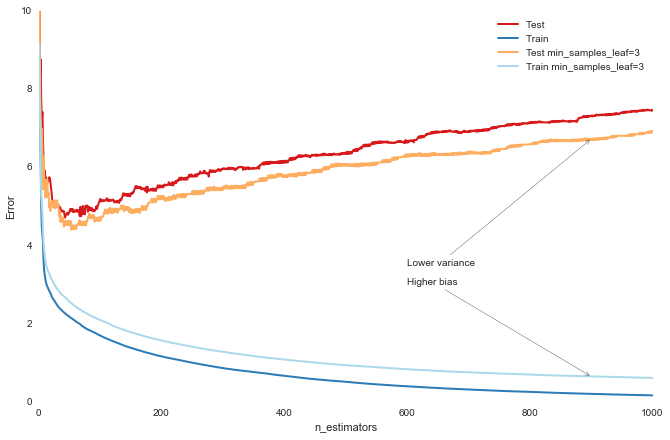

In [12]:
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.iteritems())

fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'min_samples_leaf': 3}, ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, 
                                    learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Higher bias', xy=(900, est.train_score_[899]), xytext=(600, 3), **annotation_kw)
ax.annotate('Lower variance', xy=(900, test_dev[899]), xytext=(600, 3.5), **annotation_kw)
plt.legend(loc='upper right')

## Shrinkage

 * Slow learning by shrinking the predictions of each tree by some small scalar (``learning_rate``)
 * A lower ``learning_rate`` requires a higher number of ``n_estimators``
 * Its a trade-off between runtime against accuracy.

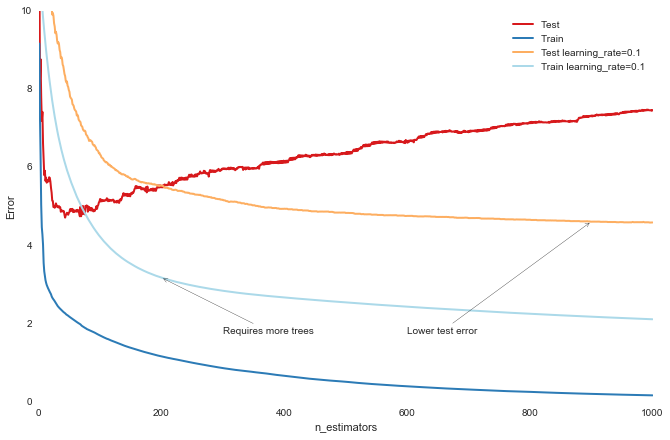

In [13]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), 
            xytext=(300, 1.75), **annotation_kw)
ax.annotate('Lower test error', xy=(900, test_dev[899]),
            xytext=(600, 1.75), **annotation_kw)
plt.legend(loc='upper right')

## Stochastic Gradient Boosting

 * Subsampling the training set before growing each tree (``subsample``)
 * Subsampling the features before finding the best split node (``max_features``)
 * Latter usually works better if there is a sufficient large number of features

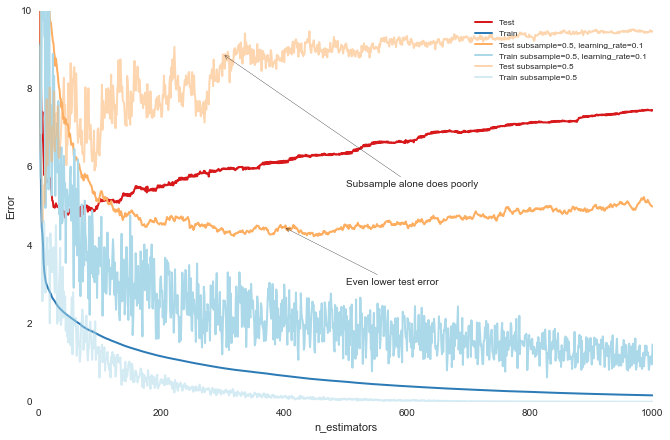

In [14]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1, 'subsample': 0.5},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0,
                                    random_state=1)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Even lower test error', xy=(400, test_dev[399]),
            xytext=(500, 3.0), **annotation_kw)

est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0,
                                subsample=0.5)
est.fit(X_train, y_train)
test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params({'subsample': 0.5}),
                             train_color='#abd9e9', test_color='#fdae61', alpha=0.5)
ax.annotate('Subsample alone does poorly', xy=(300, test_dev[299]), 
            xytext=(500, 5.5), **annotation_kw)
plt.legend(loc='upper right', fontsize='small')

## Hyperparameter tuning

I usually follow this recipe to tune the hyperparameters:

  1. Pick ``n_estimators`` as large as (computationally) possible (e.g. 3000)
  2. Tune ``max_depth``, ``learning_rate``, ``min_samples_leaf``, and ``max_features`` via grid search
  3. Increase ``n_estimators`` even more and tune ``learning_rate`` again holding the other parameters fixed

In [15]:
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5]  ## depends on the nr of training examples
              # 'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
              }

est = GradientBoostingRegressor(n_estimators=3000)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, scoring='mean_squared_error', n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)

Best hyperparameters: {'learning_rate': 0.001, 'max_depth': 6, 'min_samples_leaf': 5}


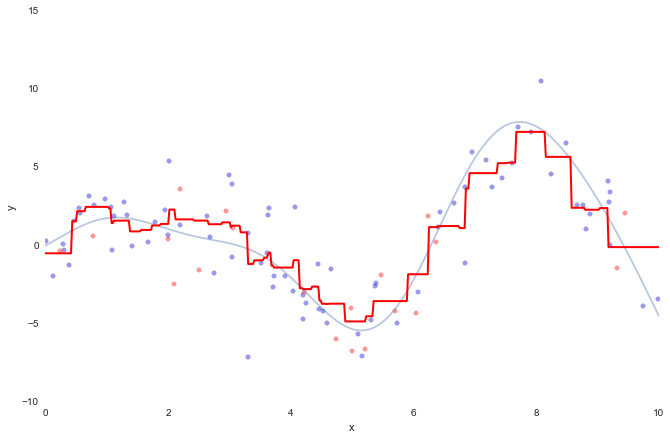

In [16]:
# refit model on best parameters
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)

# plot the approximation
plot_data()
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='r', linewidth=2)

Caution: Hyperparameters interact with each other (``learning_rate`` and ``n_estimators``, ``learning_rate`` and ``subsample``, ``max_depth`` and ``max_features``).

See [G. Ridgeway, "Generalized boosted models: A guide to the gbm package", 2005](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=540A0A638283F64E251B1342248CDBCF?doi=10.1.1.151.4024&rep=rep1&type=pdf)

In Pairs
==========================================
California Housing
------------------------------------------
<img src="assets/cal-housing.png" />  

 * Predict the median house value for census block groups in California
 * 20.000 groups, 8 features: *median income*, *average house age*, *latitude*, *longitude*, ...
 * Mean Absolute Error on 80-20 train-test split

In [17]:
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()

In [18]:
# Scikit-Learn Datasets have the following Pattern when you use load_ or make_
print cal_housing.keys()

['data', 'feature_names', 'DESCR', 'target']


In [19]:
print cal_housing.DESCR

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [20]:
cal_housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [21]:
# Look at the Target Values
cal_housing.target

array([ 4.526,  3.585,  3.521, ...,  0.923,  0.847,  0.894])

In [22]:
# How many rows exist in this dataset
cal_housing.data.shape

(20640, 8)

In [23]:
cal_housing_df = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
cal_housing_df['target'] = cal_housing.target

In [24]:
cal_housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41,6.984127,1.023810,322,2.555556,37.88,-122.23,4.526
1,8.3014,21,6.238137,0.971880,2401,2.109842,37.86,-122.22,3.585
2,7.2574,52,8.288136,1.073446,496,2.802260,37.85,-122.24,3.521
3,5.6431,52,5.817352,1.073059,558,2.547945,37.85,-122.25,3.413
4,3.8462,52,6.281853,1.081081,565,2.181467,37.85,-122.25,3.422


In [25]:
# No Missing Data and there's 20,640 rows
cal_housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 0 to 20639
Data columns (total 9 columns):
MedInc        20640 non-null float64
HouseAge      20640 non-null float64
AveRooms      20640 non-null float64
AveBedrms     20640 non-null float64
Population    20640 non-null float64
AveOccup      20640 non-null float64
Latitude      20640 non-null float64
Longitude     20640 non-null float64
target        20640 non-null float64
dtypes: float64(9)
memory usage: 1.6 MB


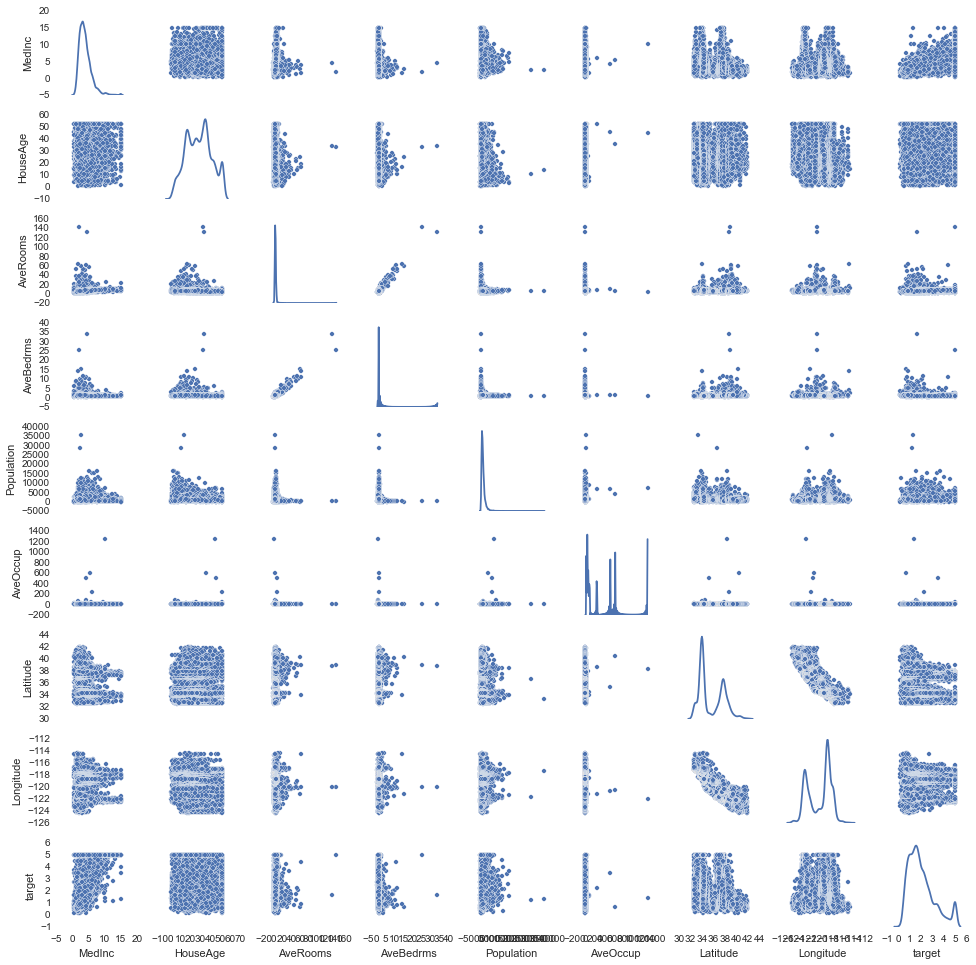

In [26]:
# Do a Pair Plot on variables to see any correlations
sns.pairplot(cal_housing_df, diag_kind='kde', size=1.5)

In [27]:
cal_housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41,6.984127,1.023810,322,2.555556,37.88,-122.23,4.526
1,8.3014,21,6.238137,0.971880,2401,2.109842,37.86,-122.22,3.585
2,7.2574,52,8.288136,1.073446,496,2.802260,37.85,-122.24,3.521
3,5.6431,52,5.817352,1.073059,558,2.547945,37.85,-122.25,3.413
4,3.8462,52,6.281853,1.081081,565,2.181467,37.85,-122.25,3.422


In [28]:
# split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2,
                                                    random_state=1)

In [29]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_scaled_train = scalar.fit_transform(X_train)
X_scaled_test = scalar.transform(X_test)

In [30]:
# Let's build a Linear Regression Model
from sklearn.linear_model import LinearRegression

lm_clf = LinearRegression(normalize=True)
lm_clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, normalize=True)

In [31]:
y_pred = lm_clf.predict(X_test)

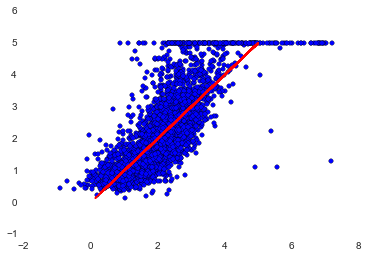

In [32]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, 'r--')

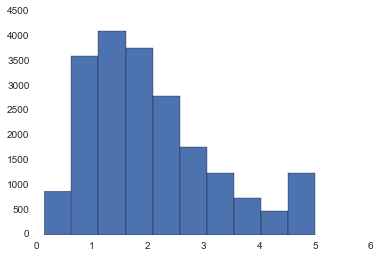

In [33]:
cal_housing_df.target.hist()

In [34]:
# R-Square
lm_clf.score(X_test, y_test)

0.59659683748122816

In [35]:
lm_clf.coef_

array([  4.38565392e-01,   9.68722037e-03,  -1.04705005e-01,
         6.32189474e-01,  -3.67690711e-06,  -3.44771323e-03,
        -4.25964056e-01,  -4.40601114e-01])

In [36]:
columns = list(cal_housing_df.columns)
columns.remove('target')

In [37]:
pd.DataFrame({'feature': columns, 'coef': lm_clf.coef_})

,coef,feature
0,0.438565,MedInc
1,0.009687,HouseAge
2,-0.104705,AveRooms
3,0.632189,AveBedrms
4,-0.000004,Population
5,-0.003448,AveOccup
6,-0.425964,Latitude
7,-0.440601,Longitude


In [38]:
# As you can see Linear Model is OK, but we could do better

## Challenges

  * heterogenous features (different scales and distributions, see plot below)
  * non-linear feature interactions (interaction: latitude and longitude)
  * extreme responses (robust regression techniques)


In [39]:
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

Task
----
1. Plot histograms of the `Latitude`, `Longitude`, Median Income (`MedInc`), and Median House Value (`y_train`)
2. Evaluate and compare the `mean_absolute_error` of 
    - `GradientBoostingRegressor` 
    - `RandomForestRegressor`
    - `DecisionTreeRegressor`
    - `DummyRegressor`
3. Tune the models (except `DummyRegressor`) as shown above  
    (this time include `max_features` as a hyperparameter):
    - Use the `deviance_plot` function defined above to check whether you are in the high-bias or high-variance regime.
    - Hint: for `DecisionTreeRegressor` and `RandomForestRegressor`, 
        look at the docs to see which hyperparameters need tuning.  
4. Plot feature importance (using the `.feature_importances_` property)
    - Hint: load `feature_importances_` into a `pandas.Series` and use `.plot(kind='barh')` 
5. `plot_partial_dependence` on `MedInc`, `AveOccup`, `HouseAge`, and `('AveOccup', 'HouseAge')`.
    - `('AveOccup', 'HouseAge')` will show you the interaction between these two features.

On Your Own
========
Go through the following tutorials on your own:

1. Decision Trees: http://scikit-learn.org/stable/modules/tree.html
2. Random Forests: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html

Then:

- Finish the California Housing assignment if you were not able to finish it in class.

In [40]:
# Let's try the Dummy Classifier, what does it do?
dummy_clf = DummyRegressor()
dummy_clf.fit(X_train, y_train)

DummyRegressor(constant=None, strategy='mean')

In [41]:
# Oh my -> We can certainly do better than that
dummy_clf.score(X_test, y_test)

-0.0014734336890012134

In [54]:
dtree_clf = DecisionTreeRegressor(max_depth=3, min_samples_leaf=3)
dtree_clf.fit(X_train, y_train)

DecisionTreeRegressor(compute_importances=None, criterion='mse', max_depth=3,
           max_features=None, max_leaf_nodes=None, min_density=None,
           min_samples_leaf=3, min_samples_split=2, random_state=None,
           splitter='best')

In [55]:
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(dtree_clf, out_file=dot_data, feature_names=cal_housing.feature_names)
print dot_data.getvalue()

digraph Tree {
0 [label="MedInc <= 5.1240\nmse = 1.33612862632\nsamples = 16512", shape="box"] ;
1 [label="MedInc <= 3.1288\nmse = 0.852004247137\nsamples = 13221", shape="box"] ;
0 -> 1 ;
2 [label="AveOccup <= 2.1588\nmse = 0.581015249547\nsamples = 6504", shape="box"] ;
1 -> 2 ;
3 [label="mse = 1.1267\nsamples = 971\nvalue = [ 1.93381591]", shape="box"] ;
2 -> 3 ;
4 [label="mse = 0.4222\nsamples = 5533\nvalue = [ 1.28394851]", shape="box"] ;
2 -> 4 ;
5 [label="AveOccup <= 2.3733\nmse = 0.846725820509\nsamples = 6717", shape="box"] ;
1 -> 5 ;
6 [label="mse = 1.3153\nsamples = 1539\nvalue = [ 2.83794558]", shape="box"] ;
5 -> 6 ;
7 [label="mse = 0.5079\nsamples = 5178\nvalue = [ 1.90481001]", shape="box"] ;
5 -> 7 ;
8 [label="MedInc <= 6.8765\nmse = 1.19607930871\nsamples = 3291", shape="box"] ;
0 -> 8 ;
9 [label="AveOccup <= 2.7283\nmse = 0.882770877754\nsamples = 2248", shape="box"] ;
8 -> 9 ;
10 [label="mse = 0.9894\nsamples = 913\nvalue = [ 3.46802108]", shape="box"] ;
9 -> 10 ;
11

In [56]:
# Another way to save the file
with ('decision_tree_clf.dot', 'w') as f:
    export_graphviz(dtree_clf, out_file=f, feature_names=cal_housing.feature_names)

AttributeError: __exit__

In [45]:
# To Visalize the .dot file, we need to install pydot
# brew install graphviz

In [57]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot

dot_data = StringIO()
export_graphviz(dtree_clf, out_file=dot_data, feature_names=cal_housing.feature_names)
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("decision_tree_clf.pdf")

True

In [92]:
# All this work to be slighty better???
dtree_clf.score(X_test, y_test)

0.61348795441596682

In [108]:
# Mean Absolute Error of Predicted vs True Y
mean_absolute_error(dtree_clf.predict(X_test), y_test)

0.41168428634003923

In [93]:
# Wait a minute, we can increase the Max Depth and that might give us better prediction?
dtree_clf = DecisionTreeRegressor(max_depth=10, min_samples_leaf=3)
dtree_clf.fit(X_train, y_train)

DecisionTreeRegressor(compute_importances=None, criterion='mse', max_depth=10,
           max_features=None, max_leaf_nodes=None, min_density=None,
           min_samples_leaf=3, min_samples_split=2, random_state=None,
           splitter='best')

In [96]:
# OK Now that's better
dtree_clf.score(X_test, y_test)

0.70595633575549099

In [97]:
# What can Random Forest do for us?
rforest_clf = RandomForestRegressor(max_depth=10, min_samples_leaf=3)
rforest_clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=10, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=3,
           min_samples_split=2, n_estimators=10, n_jobs=1, oob_score=False,
           random_state=None, verbose=0)

In [98]:
# That's a good improvement
rforest_clf.score(X_test, y_test)

0.77369374827709914

In [109]:
# Mean Absolute Error of Predicted vs True Y
mean_absolute_error(rforest_clf.predict(X_test), y_test)

0.36583482129781297

In [106]:
# Gradient Boosting now?
gb_clf = GradientBoostingRegressor(min_samples_leaf=3, max_depth=10)
gb_clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=10, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=2, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [107]:
# woo-hoo Graident Boosting Wins
gb_clf.score(X_test, y_test)

0.83438043310432153

In [110]:
# Mean Absolute Error of Predicted vs True Y
mean_absolute_error(gb_clf.predict(X_test), y_test)

0.2970518605425263

In [117]:
# Gradient Boosting now?
gb_clf2 = GradientBoostingRegressor(n_estimators=200)

In [119]:
gb_clf2.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2, n_estimators=200,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [120]:
gb_clf2.score(X_test, y_test)

0.80035682844257727